# **Injection Tutorial — KIC 10979716 (Local, Small-Grid Run)**
---

# **Background: KIC 10979716**

**KIC 10979716** is an **eclipsing binary** observed by the **Kepler** mission with an orbital period of **≈ 10.684 days**. The system shows clearly separated **primary** and **secondary eclipses**, with measured depths of **≈ 7.8%** and **≈ 5.5%**, respectively. The eclipses are short, with durations of **≈ 0.0116 days** for the primary eclipse and **≈ 0.0108 days** for the secondary eclipse. At the reference epoch, the stars have a projected separation of **≈ 0.51** in units of the binary semimajor axis.

Although there are **no confirmed circumbinary planets** known in this system, KIC 10979716 provides a clean, well behaved Kepler light curve that is ideal for testing synthetic transit injection. Its stable eclipses and simple binary configuration make it a useful benchmark for understanding how circumbinary signals appear in real data.

In this tutorial, we use **KIC 10979716** as a **sandbox system** to demonstrate how **STANLEY** injects a synthetic circumbinary planet and then attempts to recover it. The injected planet produces circumbinary transit signatures that can exhibit:

- Significant **transit timing variations (TTVs)**
- Significant **transit duration variations (TDVs)**
- Transit shapes that differ strongly from single star systems
- Visibility changes tied to the instantaneous configuration of the binary

This setup is complementary to the **Kepler 47** tutorial. While Kepler 47 contains three confirmed circumbinary planets, KIC 10979716 has no known planets, so any recovered signal comes from the **injected** planet only. This allows us to study the performance of the pipeline in a fully controlled setting.

To allow a fast, notebook friendly runtime, we use a **narrow, prior informed period window** centered on the orbital period chosen for the injected planet:

- **MinValue = 95 days**  
- **MaxValue = 110 days**

This constrained window enables a complete demonstration of injection, detrending, search, and diagnostic analysis **without requiring HPC resources**.

> **Note:**  
> Even this restricted brute force search can take a significant amount of time on a standard laptop.  
>  
> For any broad or fully blind circumbinary search, especially with wide period or parameter grids, we strongly recommend running **STANLEY** on an **HPC cluster**, since full searches are computationally intensive.


## **Import packages and STANLEY modules**

In [ ]:
from stanley_cbp import stanley_detrending, SFP, stanley_analysis
from stanley_cbp import Stanley_Functions as AC
import csv, os
import numpy as np
import pandas as pd
from IPython.display import Image, display
from scipy.ndimage import gaussian_filter1d
import uuid
from multiprocessing import Pool
from argparse import Namespace
import matplotlib.pyplot as plt
from pathlib import Path

c:\Users\tklea\anaconda3\envs\stanleynew\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
c:\Users\tklea\anaconda3\envs\stanleynew\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---
# **Detrending**

This notebook mirrors the structure of the cluster detrending workflow but reorganized for clarity and interactivity in a teaching environment. The detrending stage is essential for removing binary driven variability, instrumental systematics, and common Kepler artifacts before performing a circumbinary planet search or a synthetic planet injection.

For **KIC 10979716**, we follow the same overall structure used in the Kepler 47 tutorial, with configuration choices tuned for a clean Kepler eclipsing binary that will host a synthetic circumbinary planet.

**Goals of this section**
- Explain the capabilities of STANLEY's detrending module as applied to KIC 10979716.
- Highlight the key diagnostic figures produced by the pipeline, including:
  - Raw light curve  
  - Eclipse-fitting diagnostics  
  - Final detrended light curve used for injection and search

Notebook conventions  
Internal timing uses seconds, while plotted results are shown in days.  
All output files are written to:  
`LightCurves/Data_Preparation/<DetrendingName>/`  
`LightCurves/Figures/<DetrendingName>/`  
`LightCurves/Processed/<DetrendingName>/`  

Only the most informative figures are displayed in the tutorial.



## Configuration: STANLEY detrending module

The detrending stage in this notebook is a compact, notebook friendly wrapper around the full cluster version of STANLEY. For this system we use:

- `SystemName = "KIC10979716"`  
- `ID = 10979716`  
- `mission = "KIC"`  
- `DetrendingName = "TutorialKeplerInjection10979716"`  
- `UseSavedData = 0`  

These control file naming, data storage, and whether cached intermediates are reused.



## Detrending feature switches for KIC 10979716

These Boolean flags determine which detrending operations are applied. For this injection tutorial the configuration is:

- `detrending_quadratic`  
  Remove broad quadratic trends. Useful for TESS but not needed here. **Disabled**.

- `detrending_iterativeCosine`  
  Iterative cosine removal of periodic systematics. Main detrending method. **Enabled**.

- `detrending_plugHoles`  
  Fill large data gaps. **Disabled**.

- `detrending_variableDuration`  
  Variable duration biweight detrending. **Disabled**.

- `detrending_removeKinks`  
  Correct jump like artifacts. **Enabled**.

- `detrending_removeCommonFalsePositives`  
  Remove catalogued false positive events. **Enabled**.

- `detrending_findPotentialLedges`  
  Flag possible flux ledges. **Enabled**.

- `detrending_findDeepestPoints`  
  Identify deepest single flux points. **Enabled**.

- `detrending_plotSpecificTimes`  
  Plot selected time windows. **Disabled**.

- `detrending_saveProcessedLightCurve`  
  Save final detrended light curve. **Enabled**.

- `detrending_variableDurationXiTest`  
  Diagnostic mode. **Disabled**.

- `detrending_testCosine`  
  Diagnostic mode. **Disabled**.

For KIC 10979716, iterative cosine detrending combined with these diagnostic checks is sufficient to remove systematics while preserving astrophysical variability.



## Injection and binary physics options

Since this is an injection tutorial, we set:

- `detrending_injectTransits = True`  
  This ensures that the detrended light curve will be passed into the synthetic planet injection step.

Additional controls:

- `injection_param_file`  
  Points to a CSV inside the `Databases` folder that contains the planet parameters used during injection. **This file must be created and populated by the user.** STANLEY will read the parameters directly from this file during the injection process.

Binary physics detrending options:

- `detrending_ellipsoidal = False`  
- `detrending_reflection = False`  

These are most relevant for strongly modulated TESS systems and are not needed here.



## Plotting and binning behavior

- `_plot_trends = True`  
  Display and save trend models and intermediate diagnostics.

- `_show_plots = True`  
  Saves plots.

Time binning parameters use standard defaults appropriate for Kepler data.

All diagnostic and detrended products are written to:  
`LightCurves/Data_Preparation/<DetrendingName>/`  
`LightCurves/Figures/<DetrendingName>/`  
`LightCurves/Processed/<DetrendingName>/`  


In [ ]:
# Inputs & run label (replace these as needed)
SystemName = "KIC10979716" # KIC or TIC (e.g., "TIC 260128333" or just "260128333" depending on AC.GetID)
ID = 10979716 
mission = "KIC" # "KIC" or "TIC"
DetrendingName = "TutorialKeplerInjection10979716" # short label for figures/files
UseSavedData = 0 # 1=use cached intermediates if available, 0=fresh

# --- Feature switches ---
detrending_quadratic = False
detrending_iterativeCosine = True
detrending_plugHoles = False
detrending_variableDuration = False
detrending_removeKinks = True
detrending_removeCommonFalsePositives = True
detrending_findPotentialLedges = True
detrending_findDeepestPoints = True
detrending_plotSpecificTimes = False
detrending_saveProcessedLightCurve    = True
detrending_variableDurationXiTest = False
detrending_testCosine = False
detrending_injectTransits = True

# These were implemented primarily for data processing of TESS targets but can also run on Kepler data should you wish
# TESS targets had more variable data, iterative cosine seems to be sufficient for Kepler data
detrending_ellipsoidal = False
detrending_reflection  = False

# Plot behavior
_plot_trends = True
_show_plots = True

## **Preparing the Planet Injection Parameter File**

The synthetic circumbinary planet injected into KIC 10979716 is defined using a small CSV file located in the `UserGeneratedData` directory. This file must be created by the user before running the injection step, because STANLEY reads the planetary parameters directly from this CSV when `detrending_injectTransits` is enabled.

The file should contain the following fields:

- `KIC`  
  The Kepler ID of the target receiving the injection.

- `ep`  
  Planet eccentricity.

- `omegap`  
  Argument of periastron of the planet in radians.

- `thetap`  
  Initial orbital phase of the planet in radians.

- `Pp_days`  
  Planet orbital period in days.

- `Rp_rEarth`  
  Planet radius in Earth radii.

These values define the orbit and size of the injected circumbinary planet. Once this file is created, STANLEY can use it to generate realistic synthetic transits.



## **Injection stage: `InjectTransits_David`**

After detrending, the CSV you prepared is read by the `InjectTransits_David` function, which is responsible for adding the synthetic circumbinary planet to the light curve.

This function:

- Takes the detrended time and flux arrays.  
- Reads the injection parameters from the CSV in the `Databases` folder.  
- Computes circumbinary transit times and durations using N body timing.  
- Generates transit profiles with BATMAN using limb darkening and the binary flux ratio.  
- Writes out:
  - A parameter log describing the injection  
  - A figure showing the injected light curve  
  - A list of injected transit mid times, durations, and impact parameters  

With KIC 10979716 providing the real Kepler eclipsing binary light curve and the CSV supplying the planet parameters, this stage creates a complete synthetic circumbinary signal that can later be searched and analyzed using STANLEY.

In [ ]:
# Build the path in the user workspace
save_path = AC.p_user_data("planet_params.csv")
AC._ensure_parent(save_path)

titles = ["", "KIC", "ep", "omegap", "thetap", "Pp_days", "Rp_rEarth"]
params = [0, 10979716, 0, 0.1291298734467532, 5.092903222498788, 108.97737527999979, 6.0]

with open(save_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(titles)
    writer.writerow(params)

print(f"Saved CSV to {save_path}")

Saved CSV to C:\Users\tklea\TESSCBP\PUBLIC_RELEASE_STANLEY\Tutorials\UserGeneratedData\planet_params.csv


## Running the detrending module

`runDetrendingModule()` automatically generates a variety of diagnostic figures at each stage of the pipeline.

In this tutorial, we will:
- Let STANLEY save all figures to disk as usual.
- **Explicitly display only a curated subset of plots inline**, loading them from the output directories.

After the detrending finishes, we will focus on:

1. The **raw, sector-by-sector light curve** before any processing.  
2. The **phase-folded light curve before and after eclipse removal**.  
3. A **periodogram panel** summarizing how the detrending stages affect the frequency content.  

In [ ]:
injection_csv = AC.p_user_data("planet_params.csv")

# Build kwargs from feature switches defined in the previous cell
kwargs = dict(
    SystemName=SystemName,
    DetrendingName=DetrendingName,
    UseSavedData=UseSavedData,

    detrending_quadratic=detrending_quadratic,
    detrending_iterativeCosine=detrending_iterativeCosine,
    detrending_plugHoles=detrending_plugHoles,
    detrending_variableDuration=detrending_variableDuration,
    detrending_removeKinks=detrending_removeKinks,
    detrending_removeCommonFalsePositives=detrending_removeCommonFalsePositives,
    detrending_findPotentialLedges=detrending_findPotentialLedges,
    detrending_findDeepestPoints=detrending_findDeepestPoints,
    detrending_plotSpecificTimes=detrending_plotSpecificTimes,
    detrending_saveProcessedLightCurve=detrending_saveProcessedLightCurve,
    detrending_variableDurationXiTest=detrending_variableDurationXiTest,
    detrending_testCosine=detrending_testCosine,
    detrending_injectTransits=detrending_injectTransits,

    detrending_ellipsoidal=detrending_ellipsoidal,
    detrending_reflection=detrending_reflection,

    _plot_trends=_plot_trends,
    _show_plots=_show_plots,
)

# Only attach the CSV arg if injections are enabled *and* you provided a filename
if detrending_injectTransits and injection_csv:
    kwargs["injection_param_file"] = injection_csv

# Fire the pipeline
res = stanley_detrending.runDetrendingModule(**kwargs)

print("Detrending finished.\nSummary:")
for k, v in res.items():
    print(f"  {k}: {v}")

----- RUNNING DETRENDING CODE -----
System Name = KIC10979716
KIC = 10979716
Detrending Name = TutorialKeplerInjection10979716
------
----- DETRENDING SETTINGS -----
Quadratic = False
Iterative Cosine = True
Variable Biweight = False
Plug Holes = False
Remove Common False Positives = True
Remove Kinks = True
Remove Common False Positives = True
Find Potential Ledges = True
Find Deepest Points = True
Plot Specific Times = False
Save Processed Light Curve = True
Variable Duration Xi Test = False
Test Cosine = False
Inject Transits = True
Ellipsoidal Detrending = False
Reflection Detrending = False
------
----- LOADING SYSTEM -----
Searching for orbit data in Villanova catalog
Orbit data found from Villanova catalog
Secondary eclipse found, calculating eccentricity and omega
Searching for stellar data in Windemuth catalog
Stellar data found in Windemuth catalog
timeOrig: [4.74893383e+09 4.74893560e+09 4.74893913e+09 ... 4.87503017e+09
 4.87503193e+09 4.87503370e+09]
phase_orig: [0.7594246

---
## **Detrending Diagnostics**


Plotting raw light curve:

Showing: raw light curve


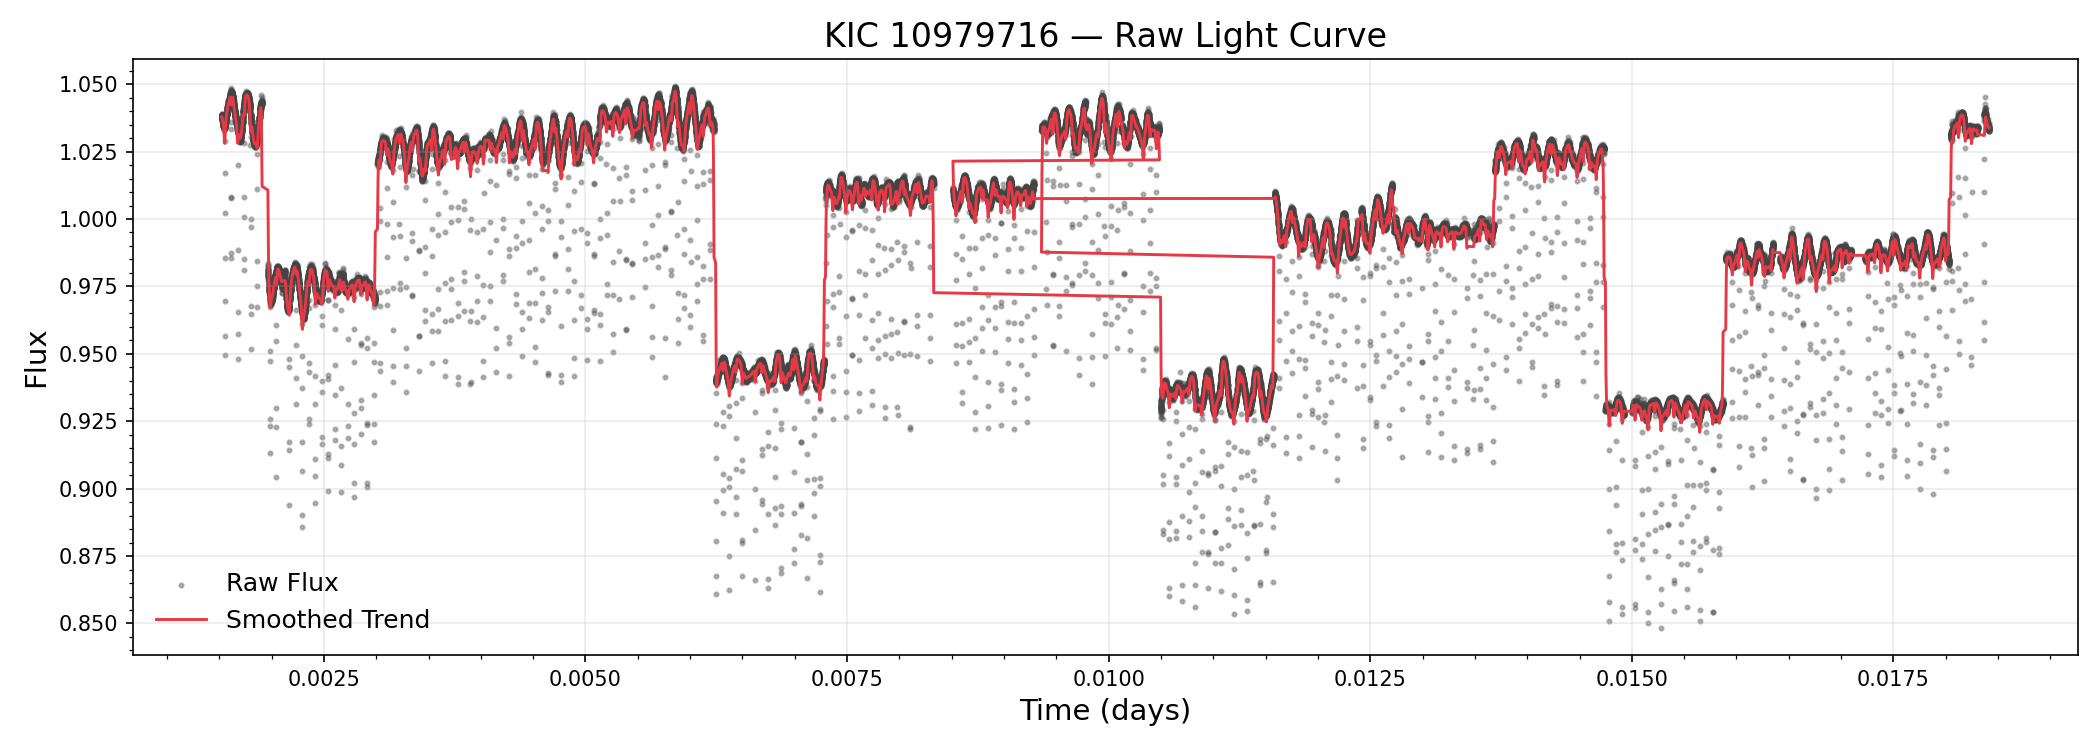


Displaying key diagnostic plots (in order):

Showing: KIC_10979716_phase_folded_original_data.png


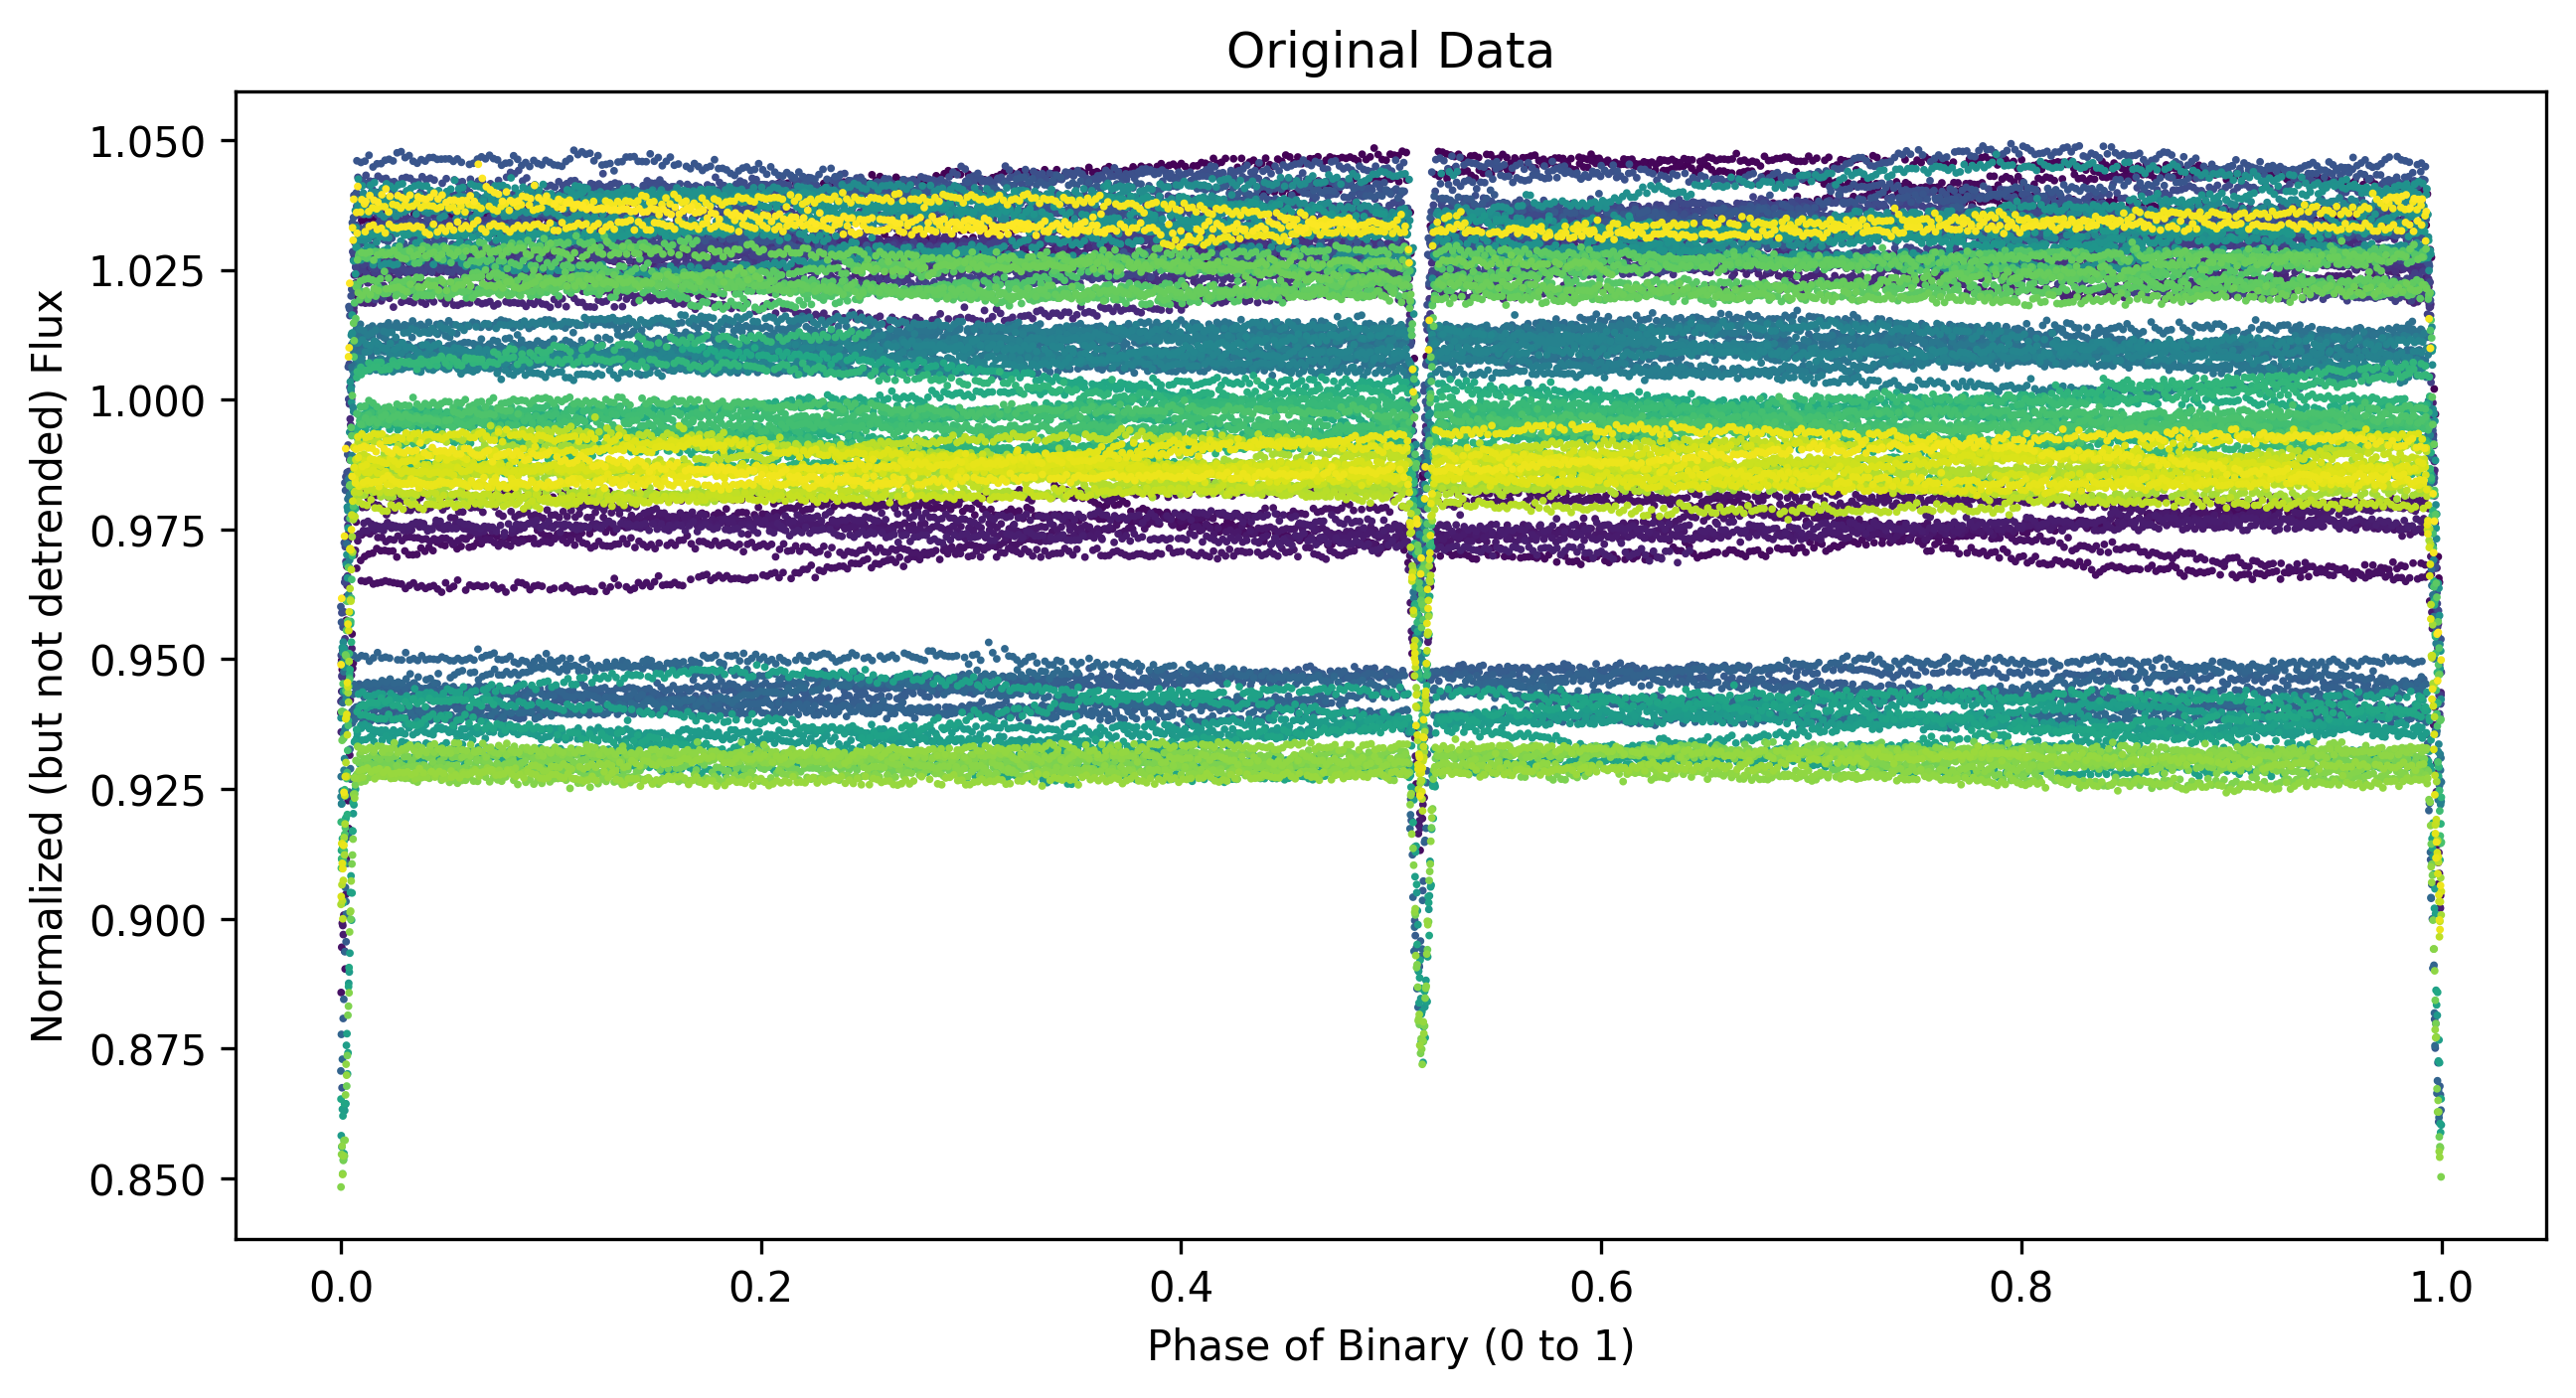

Showing: KIC_10979716_phase_folded_eclipses_removed.png


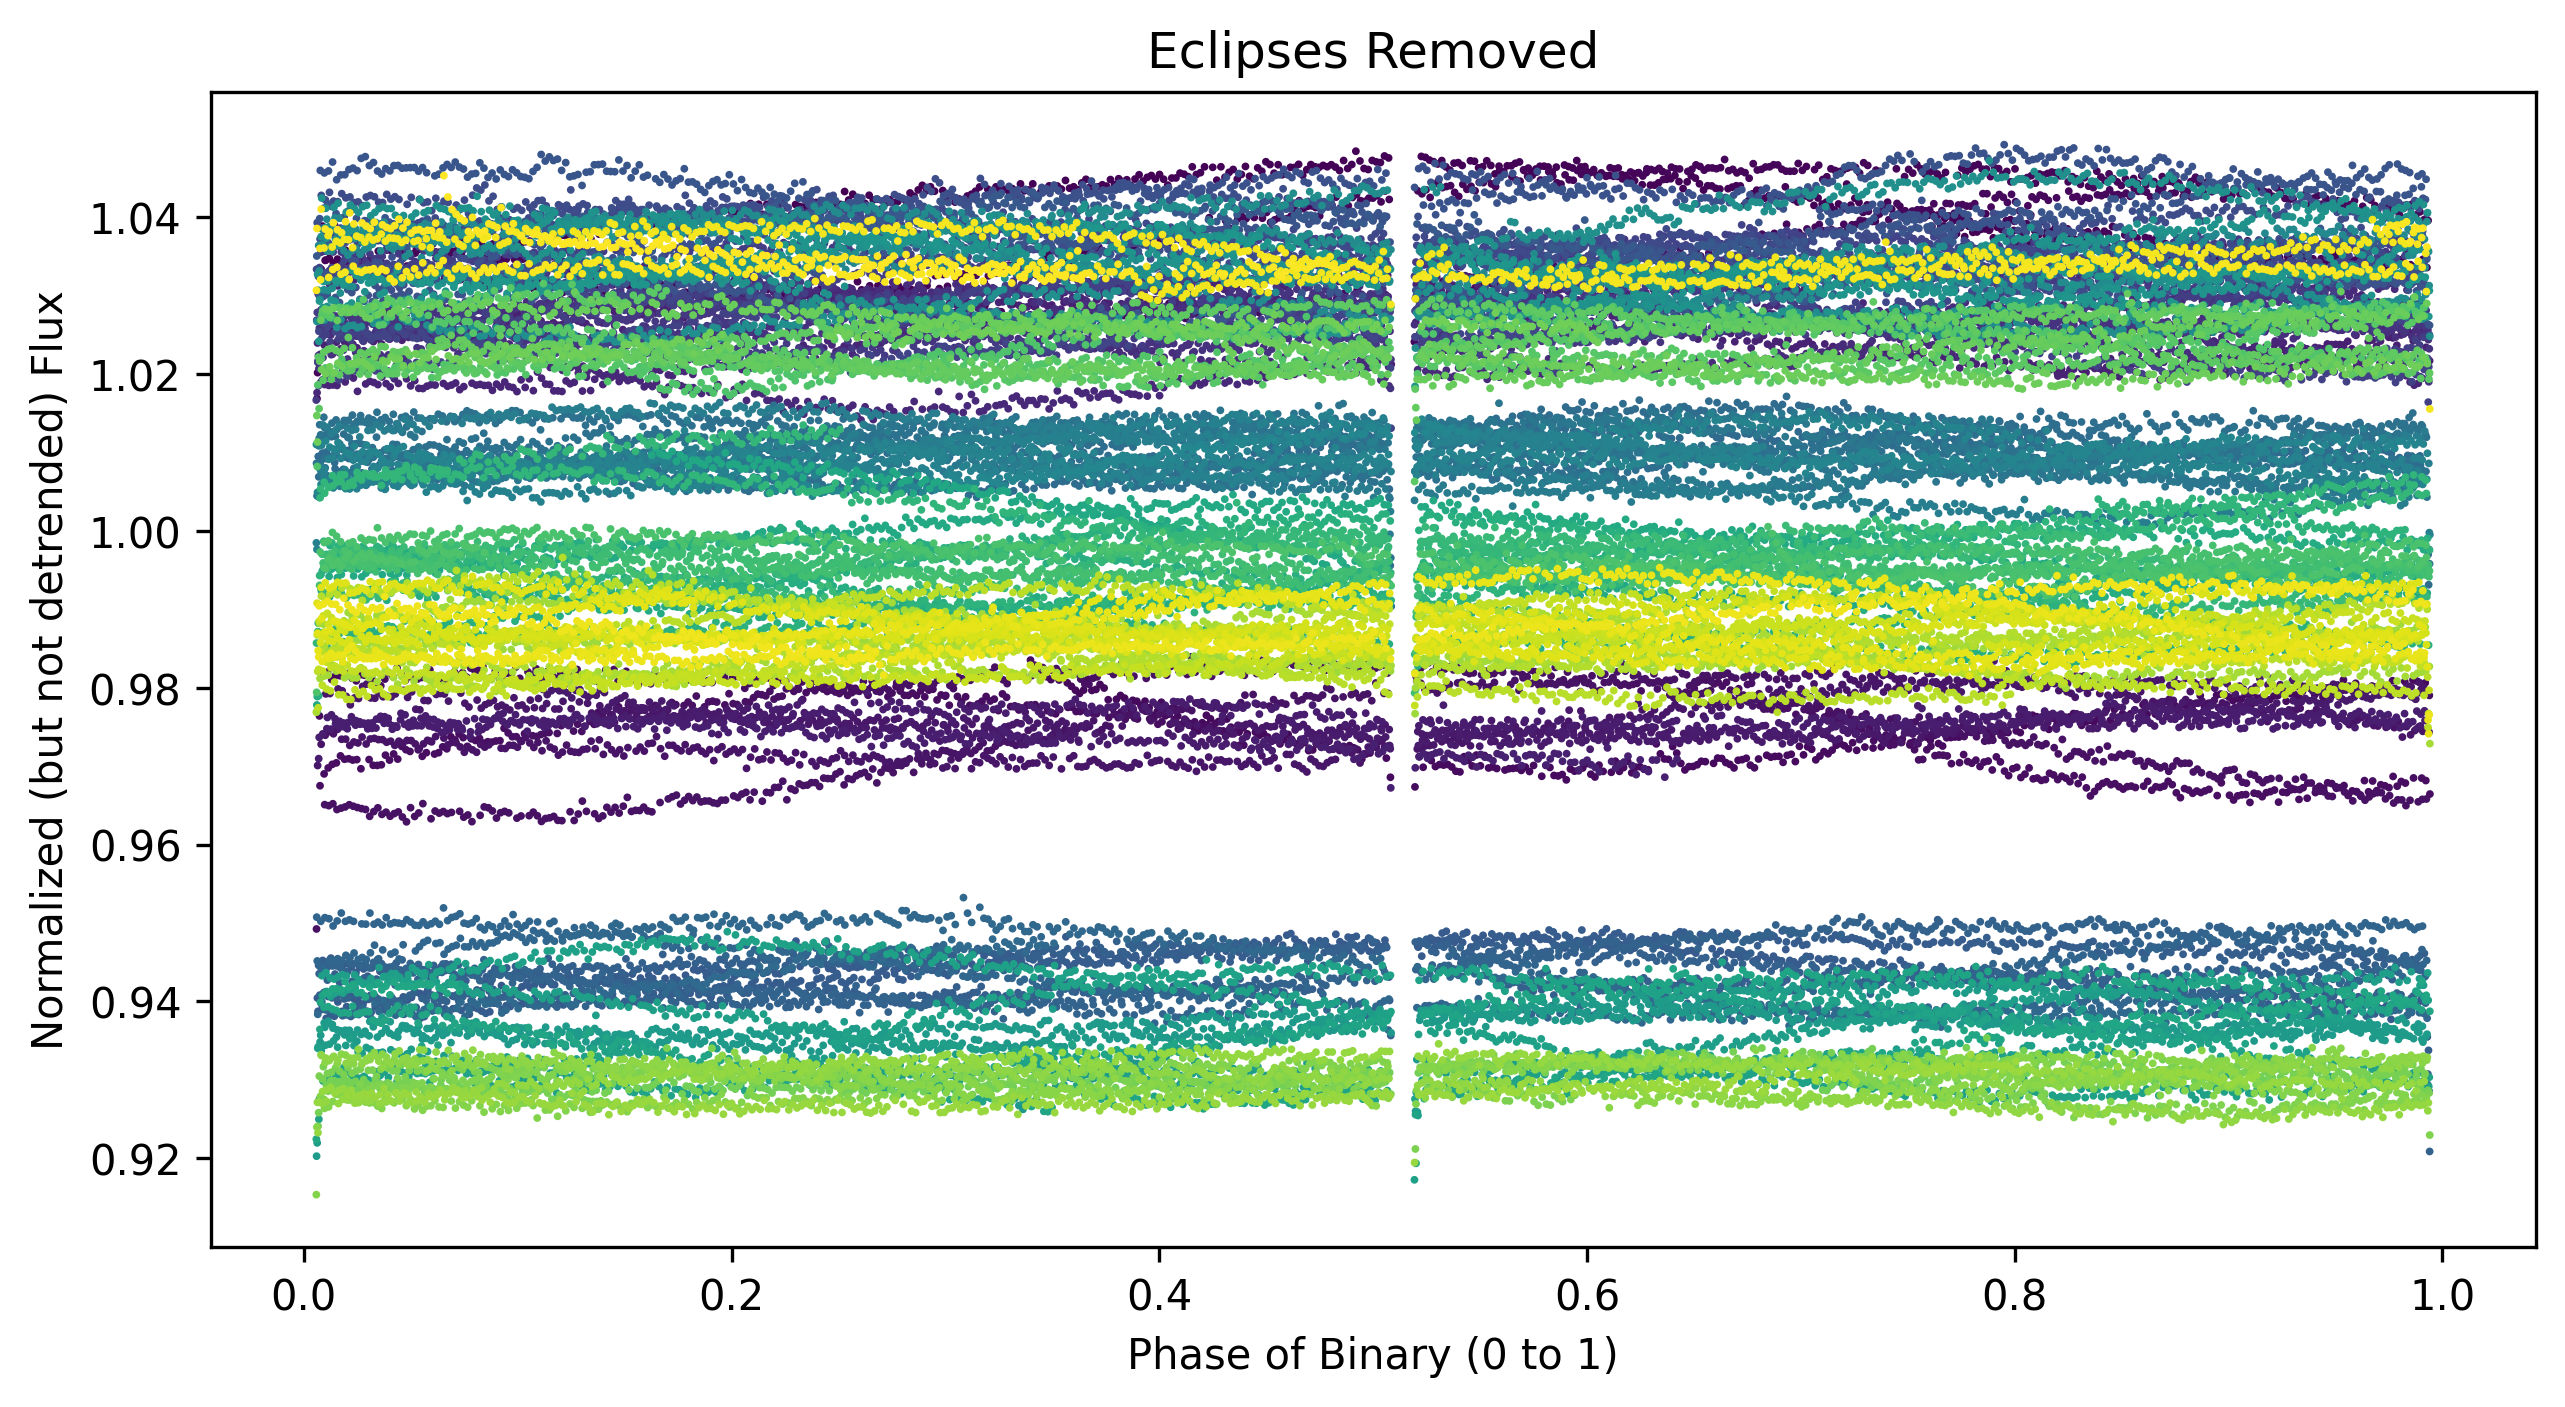

Showing: KIC_10979716_TutorialKeplerInjection10979716_periodograms.png


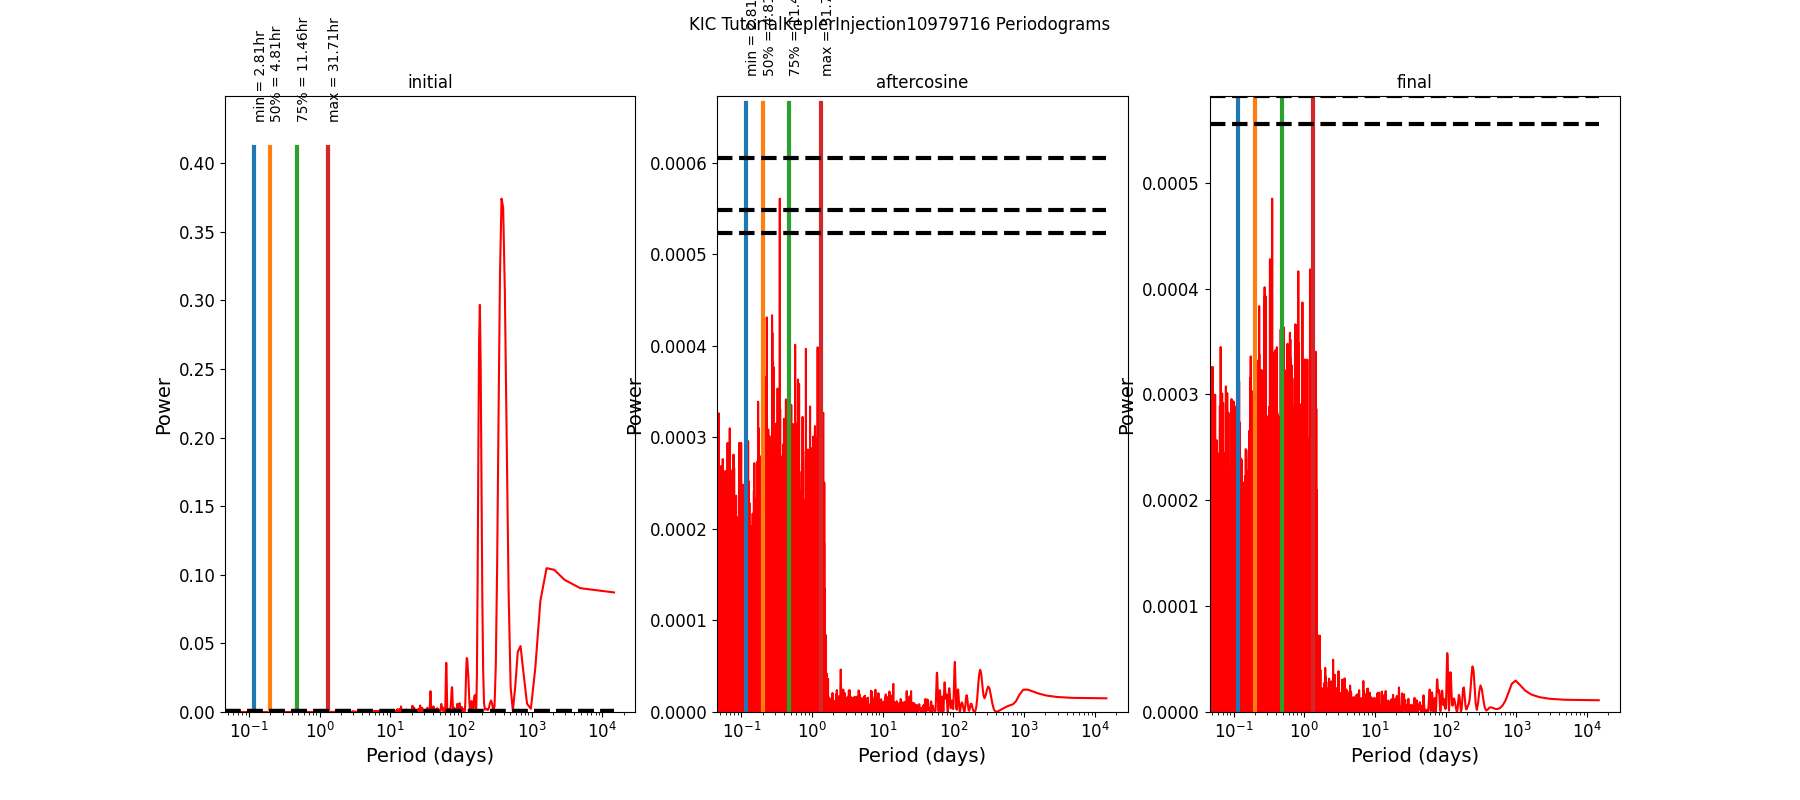

In [3]:
# Paths
fig_dir = os.path.join("LightCurves", "Figures", DetrendingName)
data_prep = os.path.join("LightCurves", "Data_Preparation", DetrendingName)
raw_dir = os.path.join("LightCurves", "Raw")
raw_file = os.path.join(raw_dir, f"{ID}_raw.csv")

print("\nPlotting raw light curve:\n")

if os.path.exists(raw_file):

    # Load whitespace-delimited: [time_sec, flux, flux_err]
    raw = np.genfromtxt(raw_file)
    if raw.ndim == 1:
        raw = raw.reshape(1, -1)

    time_sec  = raw[:, 0]
    flux_raw  = raw[:, 1]
    time_days = time_sec / 86400.0

    # Gentle smoothing for visual clarity
    smoothed = gaussian_filter1d(flux_raw, sigma=20)

    # Make sure folder exists for the temp file
    os.makedirs(data_prep, exist_ok=True)
    tmp_png = os.path.join(data_prep, f"{mission}_{ID}_raw_lightcurve_tmp_{uuid.uuid4().hex}.png")

    # Plot layout
    plt.figure(figsize=(14, 5))

    plt.scatter(time_days, flux_raw, s=4, color="#444444", alpha=0.35, label="Raw Flux")

    plt.plot(time_days, smoothed, color="#E63946", linewidth=1.4, label="Smoothed Trend")

    plt.xlabel("Time (days)", fontsize=14)
    plt.ylabel("Flux", fontsize=14)
    plt.title(f"{mission} {ID} — Raw Light Curve", fontsize=16)

    plt.grid(True, alpha=0.25)
    plt.minorticks_on()
    plt.legend(frameon=False, fontsize=12)

    plt.tight_layout()
    plt.savefig(tmp_png, dpi=150)
    plt.close()

    print("Showing: raw light curve")
    display(Image(filename=tmp_png, width=950))

    # Remove temp file so it doesn't persist on disk, we are simply plotting for a visual diagnostic within the tutorial
    try:
        os.remove(tmp_png)
    except OSError:
        pass

else:
    print(f"Missing raw file: {raw_file}")

important_figs = [
    f"{mission}_{ID}_phase_folded_original_data.png",
    f"{mission}_{ID}_phase_folded_eclipses_removed.png",
    f"{mission}_{ID}_{DetrendingName}_periodograms.png",
]

print("\nDisplaying key diagnostic plots (in order):\n")

for fname in important_figs:
    # Look in Figures first, then Data_Preparation
    possible_paths = [os.path.join(fig_dir, fname), os.path.join(data_prep, fname),]
    
    displayed = False
    for path in possible_paths:
        if os.path.exists(path):
            print(f"Showing: {fname}")
            display(Image(filename=path, width=950))
            displayed = True
            break
    
    if not displayed:
        print(f"Missing: {fname}")


---
## **Search**

`Stanley_FindPlanets()` performs the circumbinary planet search by forward modeling an N body grid of planetary orbits and comparing the resulting transit masks to the detrended light curve. This search evaluates a wide range of possible planetary configurations and identifies which are most consistent with the synthetic circumbinary signal injected into KIC 10979716.


The search proceeds as follows:

- It constructs a grid of **planetary orbital parameters**, including the orbital period *Pp*, eccentricity *ep*, argument of periastron *omegap*, and true anomaly *thetap*. The binary parameters were established during the detrending stage and remain fixed in this example.

- For each grid point, an **N body–based transit mask** is generated that predicts where transits should occur.

- Each mask is compared to the detrended light curve and assigned a **significance value σ**, indicating how well that planetary configuration explains the data. Interpolation between true anomaly samples is used when `N_interp > 1`.

- All σ grids and intermediate results are written to `PlanetSearchOutput/<SearchName>/` for later inspection and visualization.

For the KIC 10979716 injection tutorial, we configure `Stanley_FindPlanets` in a minimal but complete mode that is suitable for running inside a Jupyter notebook while still demonstrating the full circumbinary search procedure.

### **Notebook Search Configuration**

- `TotalSectors = 4`  
  The light curve is split into four sectors (quarters), each searched separately.

- `currentSector = 1`  
  This cell initiates the search for the first sector; the parallel call processes all four.

- `OnCluster = 0`  
  Enables local progress bar output instead of cluster execution behavior.

- `N_interp = 2`  
  Applies light interpolation between sampled values of the true anomaly.

- `BoundsType = "days to days"`  
  The period grid is supplied directly in days.

- `MinValue = 95`, `MaxValue = 110`  
  A **narrow, prior informed period window** centered on the orbital period of the injected synthetic planet.  
  This keeps the runtime reasonable while still demonstrating the key features of a CBP search.

- `e_max_planet = 0.0`  
  Planet eccentricity is fixed to zero for this tutorial.

This search step does not display diagnostic plots directly. Instead, it produces the full high dimensional significance grid that the analysis stage will convert into summary plots, SDE maps, and candidate diagnostics.

### **Tutorial Goals**

1. Verify that a circumbinary planet search for the injected planet in KIC 10979716 completes successfully across multiple sectors.  
2. Understand where search outputs are written on disk and how they are organized.  
3. Use the analysis module to visualize the σ grid, generate SDE summaries, and examine the detectability of the injected circumbinary planet.


In [6]:

TotalSectors = 4
OnCluster = 0
SearchName = 'TutorialSearch_KeplerInjection10979716'
SystemName = SystemName
DetrendingName = DetrendingName
N_interp = 2
BoundsType = 'days to days'
MinValue = 95
MaxValue = 110
e_max_planet = 0.0

args = Namespace(
    searchName=SearchName,
    systemName=SystemName,
    detrendingName=DetrendingName,
    totalSectors=TotalSectors,
    currentSector=1,
    onCluster=OnCluster,
    parallel=1,
    interpolationValue=N_interp,
    boundsType=BoundsType,
    minValue=MinValue,
    maxValue=MaxValue,
    e_max_planet=e_max_planet,
)

SFP.parallel(args)

print("Search finished for all sectors (parallel).")

---
## **Analysis**

After the search has completed, we call `runAnalysisModule` to turn the high-dimensional
search outputs into a small set of **human-interpretable diagnostics**.

Conceptually, `runAnalysisModule`:

- **Loads the search context and detrended light curve**  
  using the `simInfo` file, the saved detrended CSV associated with the same `DetrendingName`,
  and the binary starting parameters.

- **Reads and aggregates the search grids**  
  by loading the `searchParameters_array` and concatenating the
  `searchResults_array_*` files in `PlanetSearchOutput/<SearchName>/`
  across all θₚ sectors.

- **Builds a 1D detection statistic as a function of planet period**  
  by combining the multi-dimensional significance grid over the remaining
  parameters (masses, binary elements, eccentricity *eₚ*, argument of periastron *ωₚ*,
  and true anomaly *θₚ*), and then computing an SDE curve vs. period.

- **Selects the best-fit model at the SDE peak**  
  and extracts the corresponding `(Pₚ, eₚ, ωₚ, θₚ)` combination, along with the
  associated binary parameters.

- **Reconstructs transit times and durations** for the best-fit configuration  
  and generates:
  - A **TTV (Transit Timing Variations)** plot  
  - A **TDV (Transit Duration Variations)** plot  
  - A concise, human-readable summary text file  
  - Helper files with transit windows and discovered transit lists for downstream vetting.

This tutorial uses **four sectors** on the local notebook. We still call `runAnalysisModule` so the workflow matches the full multi-sector/cluster use case:

- The same analysis call works when `totalSectors > 1`.  
- The module automatically discovers and loads all sector outputs for `searchName` and `systemName`.  
- The returned `result` dictionary provides a compact summary (e.g., peak SDE value and best-fit period) that we can inspect directly in the notebook.


In [4]:
SearchName = 'TutorialSearch_KeplerInjection10979716'
TotalSectors = 4
currentSector = 1
OnCluster = 0
result = stanley_analysis.runAnalysisModule(
    searchName=SearchName,
    systemName=SystemName,
    totalSectors=TotalSectors,
    currentSector=1,
    onCluster=OnCluster,
)

print("Analysis finished.")
print("Summary:")
for k, v in result.items():
    print(f"  {k}: {v}")

[2025-12-07 00:20:12.524305] Analysis expecting simInfo at: C:\Users\tklea\TESSCBP\PUBLIC_RELEASE_STANLEY\Tutorials\PlanetSearchOutput\TutorialSearch_KeplerInjection10979716\KIC_10979716_simInfo.npy
Loading results for searchName = TutorialSearch_KeplerInjection10979716, systemName = KIC10979716, detrendingName = TutorialKeplerInjection10979716
4 sector(s) loaded
Create 1D SDE
[SDE diag] N=307 kept=293 (95.44%) initialSTD=5.34353 clipSTD=1.34292 denom=initialSTD max=8.270
[SDE] Max=8.270 at 108.91773 d
1D SDE created
Getting best fitting transit times
we have entered the plotting statement
meanPlanetTransitInterval (sec): 9230968.77819427
scaledWindowTime size: 46, totalWindowFlux size: 46
meanScaledFlux_time size: 14, meanScaledFlux size: 14
sigma_solutionOld = 53.50263160734242
meanFlux_solution = -0.005811011333711055
No known transits file found
[create_search_analysis_diagnostic_report] Writing PDF to: C:\Users\tklea\TESSCBP\PUBLIC_RELEASE_STANLEY\Tutorials\PlanetSearchOutput\..\D

---
## **Search & Analysis Diagnostics and Results**


Search and analysis diagnostic plots:

Showing: 10979716_KICSDEpaper.png


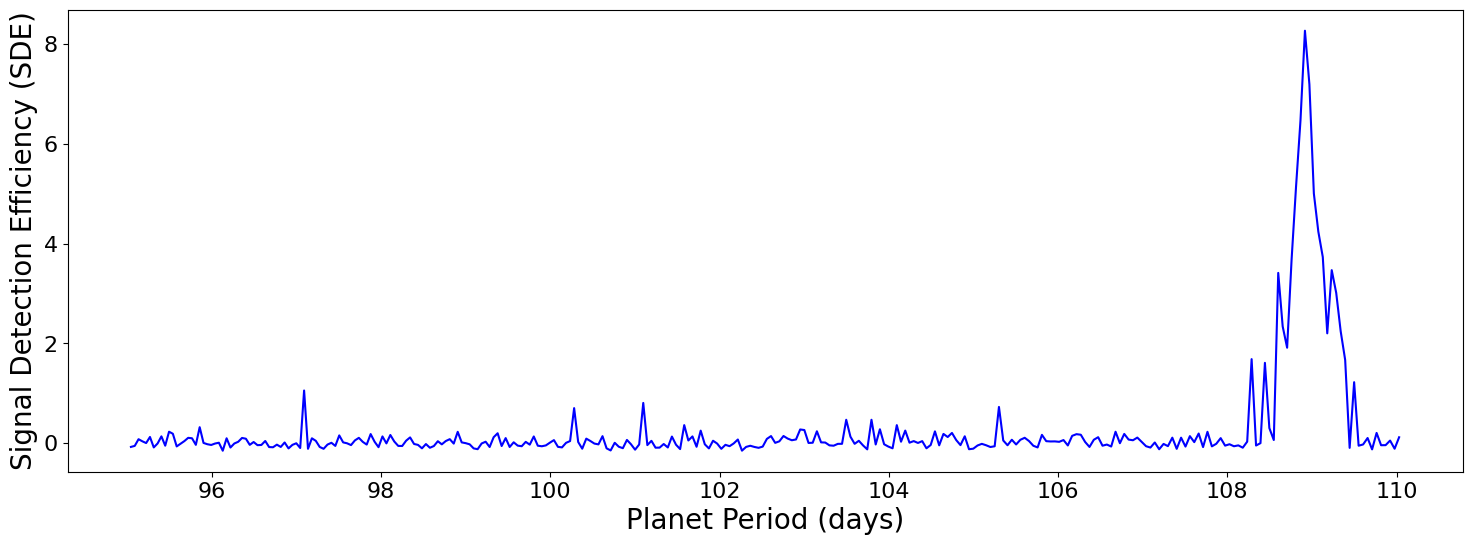

Showing: KIC_10979716_IndividualPlanetTransitsWiderWindow.png


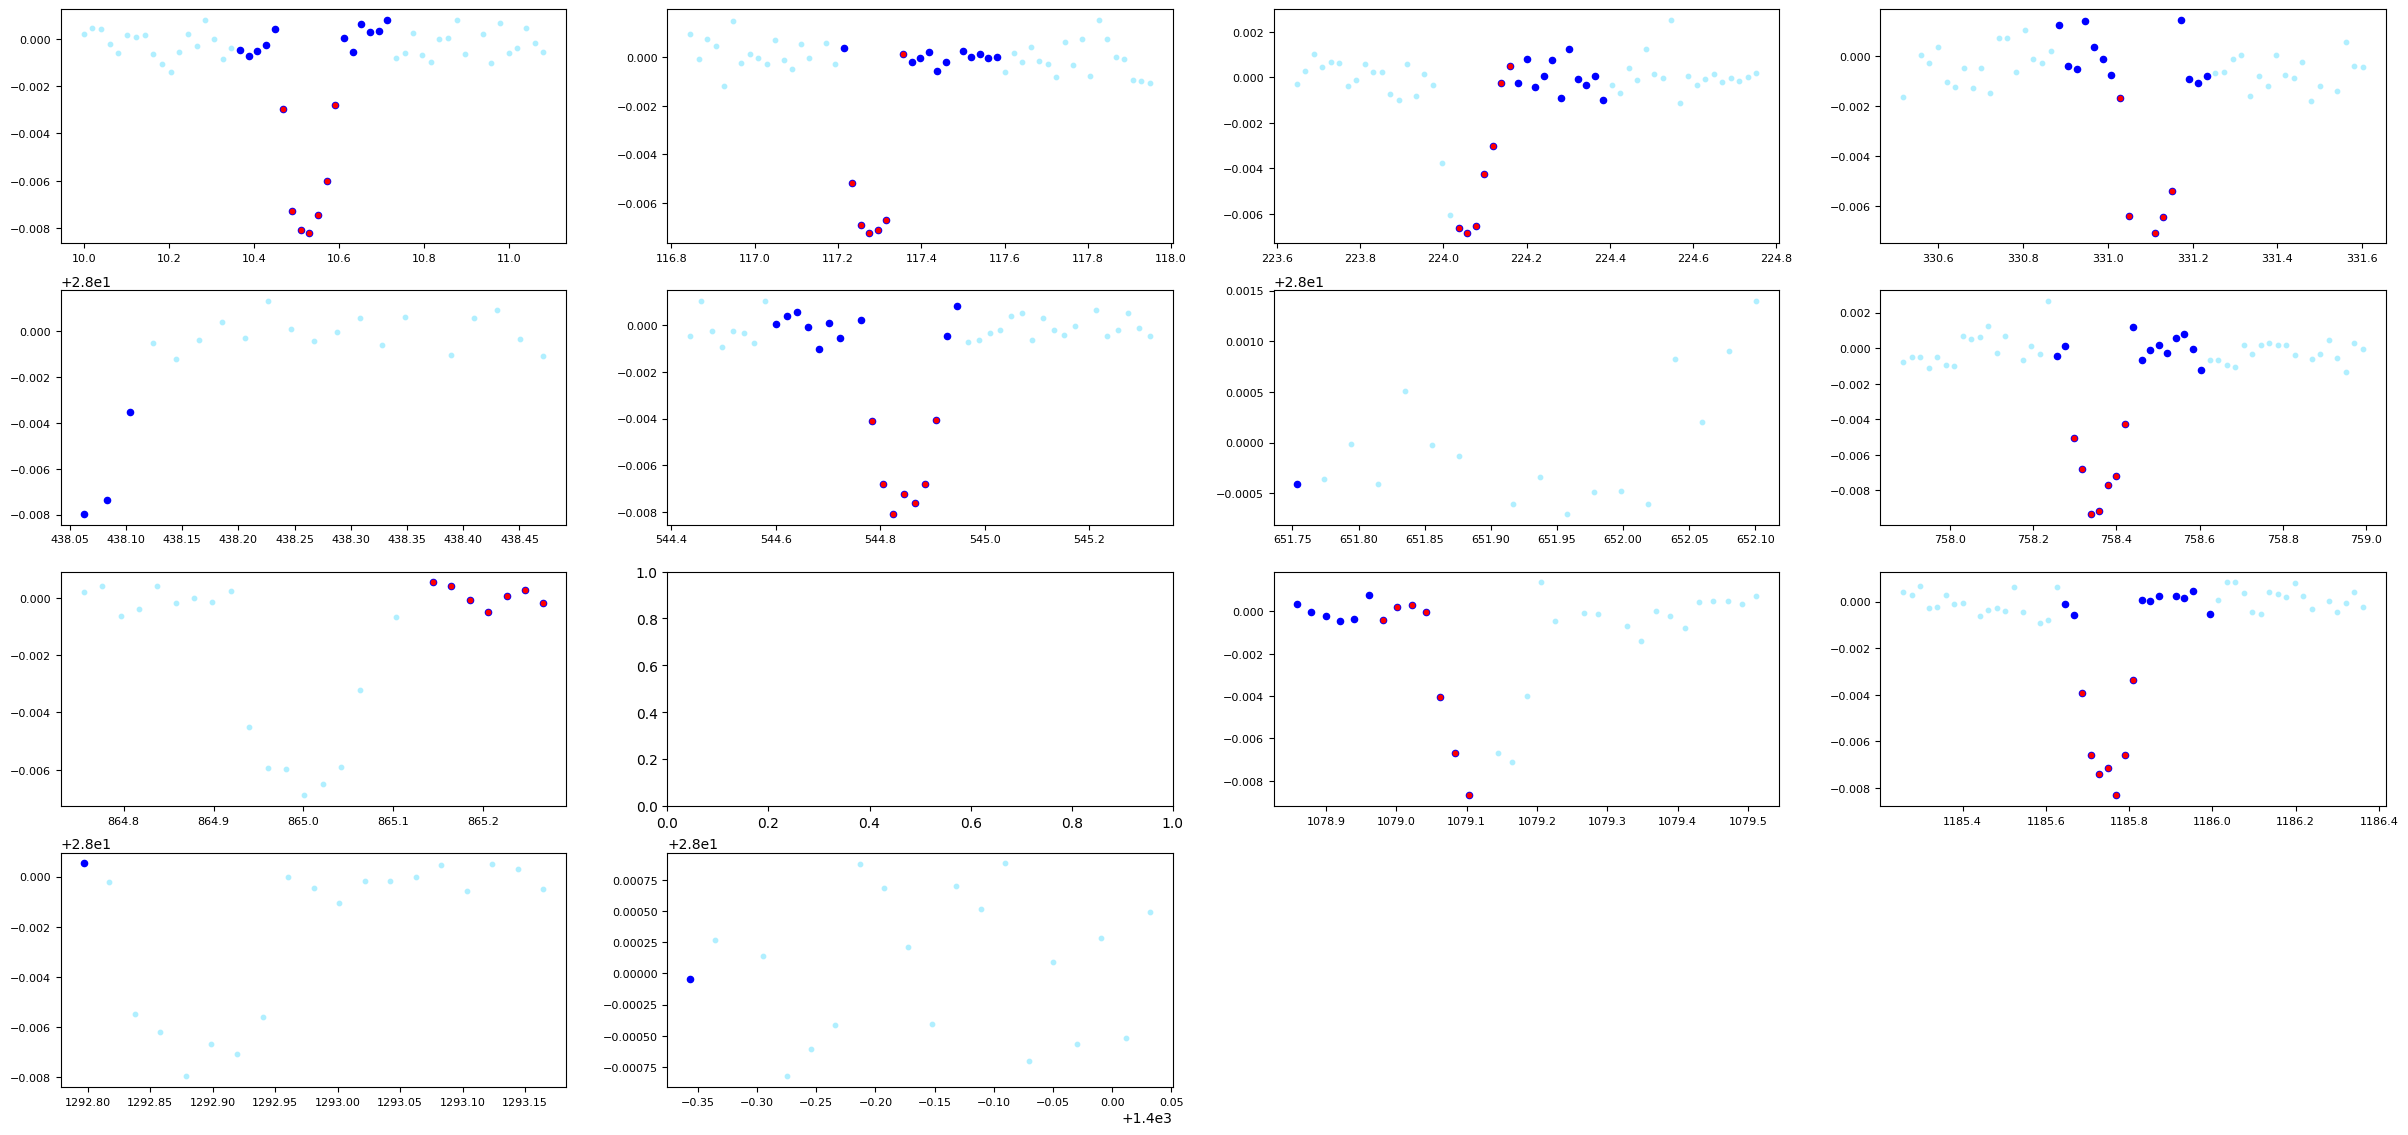

Showing: KIC_10979716_FoldedPlanetTransits.png


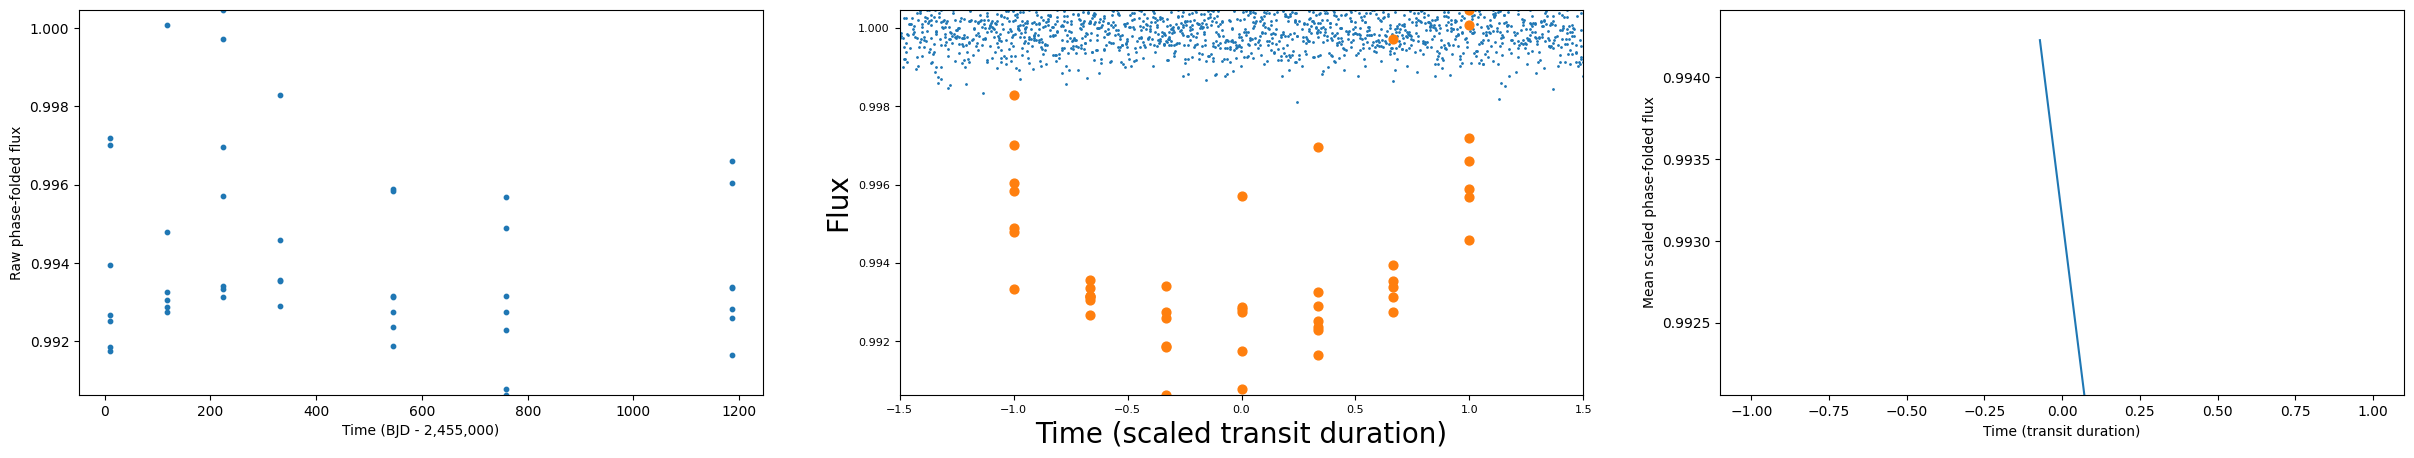



         Search Summary

System name                   : KIC10979716
mission + ID                  : KIC_10979716
Search name                   : TutorialSearch_KeplerInjection10979716
Detrending name               : TutorialKeplerInjection10979716
Total sectors                 : 4
Num Theta_p steps             : 312
Search parameter count        : 90060
SDE_1d (max value)            : 8.269970048061381
SDE_1d (period)               : 108.91772707087254
Pp (days)                     : 108.9177 days
ep                            : 0.0
omegap (deg)                  : 0.0 deg
thetap (deg)                  : 293.3766 deg
Transit timing (best fit)     : 10.53, 117.288, 224.098, 331.095, 438.0, 544.845, 652.0, 758.359, 865.205, 972.0, 1079.042, 1185.748, 1293.0, 1399.0

Done.


In [ ]:
# Display and interpret our search results
fig_dir = os.path.join("PlanetSearchOutput", SearchName)

# Note that an SDE value of above 8 is considered a detection
analysis_figs = [
    f"{ID}_{mission}SDEpaper.png",
    f"{mission}_{ID}_IndividualPlanetTransitsWiderWindow.png",
    f"{mission}_{ID}_FoldedPlanetTransits.png",
]

print("\nSearch and analysis diagnostic plots:\n")

for fname in analysis_figs:
    path = os.path.join(fig_dir, fname)
    if os.path.exists(path):
        print(f"Showing: {fname}")
        display(Image(filename=path, width=950, height=400))
    else:
        print(f"Missing: {fname}")


results_file = os.path.join(fig_dir, f"{mission}_{ID}_SearchResults.txt")

print("\n\n==============================")
print("         Search Summary")
print("==============================\n")

if not os.path.exists(results_file):
    print(f"SearchResults file missing: {results_file}")
else:
    summary = {}
    with open(results_file, "r") as f:
        for line in f:
            if "=" in line:
                k, v = line.strip().split("=", 1)
                summary[k.strip()] = v.strip()

    keys_to_show = [
        "System name",
        "mission + ID",
        "Search name",
        "Detrending name",
        "Total sectors",
        "Num Theta_p steps",
        "Search parameter count",
        "SDE_1d (max value)",
        "SDE_1d (period)",
        "Pp (days)",
        "ep",
        "omegap (deg)",
        "thetap (deg)",
        "Transit timing (best fit)"
    ]

    for k in keys_to_show:
        print(f"{k:30s}: {summary.get(k, '---')}")

print("\nDone.")

---
## **Evaluate Recovery**

To assess how well the search recovered the injected circumbinary planet, we compare each **injected transit** to the **closest detected event** from the search output. A transit is counted as recovered when the detected event occurs within the combined time window of the injected and detected durations. This overlap test accounts for the natural timing variations present in circumbinary systems. By checking each injected mid time against the nearest detected one, we can determine how many synthetic events were successfully identified by the pipeline.


In [ ]:
SearchName = 'TutorialSearch_KeplerInjection10979716'

def evaluate_transit_recovery_overlap(
    injected_times,
    injected_durations,
    detected_times,
    detected_durations,
    extra_slack=0.0, # optional: days of extra margin beyond pure overlap
):
    """
    injected_times : 1D array-like, mid-times of injected transits (days)
    injected_durations : 1D array-like, durations of injected transits (days)
    detected_times : 1D array-like, mid-times of detected transits (days)
    detected_durations : 1D array-like, durations of detected transits (days)
    extra_slack : extra allowed margin in days beyond strict overlap

    A transit is counted as 'recovered' if the detected transit's window
    overlaps the true injected transit window, i.e. 
    |t_det - t_inj| <= 0.5*(D_inj + D_det) + extra_slack
    """

    injected_times = np.asarray(injected_times, dtype=float).ravel()
    injected_durations = np.asarray(injected_durations, dtype=float).ravel()
    detected_times = np.asarray(detected_times, dtype=float).ravel()
    detected_durations = np.asarray(detected_durations, dtype=float).ravel()

    n_inj = len(injected_times)
    recovered_flags = np.zeros(n_inj, dtype=bool)
    matched_indices = np.full(n_inj, -1, dtype=int)
    time_diffs = np.full(n_inj, np.nan)
    overlap_margins = np.full(n_inj, np.nan)  # how far inside / outside overlap we are

    if detected_times.size == 0:
        print("No detected transits provided.")
        return recovered_flags, matched_indices, time_diffs

    print("Injected_idx | t_inj (d)       | D_inj (d)    | Closest t_det (d)  | D_det (d)    "
          "| |Δt| (d)     | overlap_limit (d) | Recovered?")
    print("-" * 120)

    for i, (t_inj, D_inj) in enumerate(zip(injected_times, injected_durations)):

        # Find closest detected event in time
        idx = np.argmin(np.abs(detected_times - t_inj))
        t_det = detected_times[idx]
        D_det = detected_durations[idx]

        dt = t_det - t_inj
        abs_dt = abs(dt)

        # strict overlap condition (plus optional extra_slack)
        overlap_limit = 0.5 * (D_inj + D_det) + extra_slack

        recovered = abs_dt <= overlap_limit

        recovered_flags[i] = recovered
        matched_indices[i] = idx
        time_diffs[i] = dt
        overlap_margins[i] = overlap_limit - abs_dt

        rec_str = "YES" if recovered else "NO"
        print(f"{i:11d} | {t_inj:14.9f} | {D_inj:11.6f} | "
              f"{t_det:16.9f} | {D_det:11.6f} | "
              f"{abs_dt:10.6f} | {overlap_limit:15.6f} | {rec_str:>9}")

    n_recovered = recovered_flags.sum()
    print(f"\nRecovered {n_recovered} out of {n_inj} injected transits.")
    if n_recovered >= 3:
        print("At least 3 transits were recovered based on overlap.")
    else:
        print("Fewer than 3 transits were recovered based on overlap.")

    return recovered_flags, matched_indices, time_diffs

injected_times_csv = pd.read_csv(f'LightCurves/Injections/{DetrendingName}/{ID}_injectedTransitList.txt', delimiter=' ', header=None)
injected_times = injected_times_csv.iloc[:, 0].values
injected_duration = injected_times_csv.iloc[:, 1].values
detected_transits_csv = pd.read_csv(f'PlanetSearchOutput/{SearchName}/{mission}_{ID}_discoveredTransitList.txt', delimiter=' ', header=None)
detected_times = detected_transits_csv.iloc[:, 0].values
detected_duration = detected_transits_csv.iloc[:, 1].values
recovered_flags, matched_indices, time_diffs = evaluate_transit_recovery_overlap(
    injected_times,
    injected_duration, 
    detected_times,
    detected_duration, 
    extra_slack=0.0 
)


Injected_idx | t_inj (d)       | D_inj (d)    | Closest t_det (d)  | D_det (d)    | |Δt| (d)     | overlap_limit (d) | Recovered?
------------------------------------------------------------------------------------------------------------------------
          0 |   10.529835767 |    3.260709 |     10.529835767 |    2.959963 |   0.000000 |        3.110336 |       YES
          1 |  117.288072535 |    3.277651 |    117.288072535 |    2.966469 |   0.000000 |        3.122060 |       YES
          2 |  224.057212142 |    3.295074 |    224.098078983 |    2.956404 |   0.040867 |        3.125739 |       YES
          3 |  331.094634223 |    3.312987 |    331.094634223 |    2.962862 |   0.000000 |        3.137924 |       YES
          4 |  438.042105289 |    3.331397 |    438.000000000 |    2.969539 |   0.042105 |        3.150468 |       YES
          5 |  544.845473018 |    3.350312 |    544.845473018 |    2.976434 |   0.000000 |        3.163373 |       YES
          6 |  651.504734050 |    3

---
## **Interpretation**

This tutorial successfully executed the full STANLEY circumbinary pipeline on the eclipsing binary **KIC 10979716**, including detrending, planet injection, the circumbinary planet search, and the final transit recovery analysis.

### Key outcomes

- **Detrending completed successfully**, producing a clean and stable light curve suitable for transit injection and subsequent recovery tests.

- A synthetic circumbinary planet was injected using parameters supplied through the user created CSV file in the `Databases` directory. The injected planet produced fourteen transits across the observational baseline.

- The planet search evaluated **90,060 parameter combinations** across the demonstration grid of *(Pp, thetap, ep, omegap)* with **312 thetap samples**.

- The **one dimensional SDE curve** showed a clear peak within the restricted period window:
  - **SDE_max ≈ 8.27**
  - **Peak period ≈ 108.918 days**

- The best fit search result recovered the injected planet parameters within the limits of the demonstration grid:
  - **Planet model selected by the grid:**
    - $P_p \approx 108.918 \text{ days}$
    - $e_p = 0$
    - $\omega_p = 0^{\circ}$
    - $\theta_p \approx 293.38^{\circ}$  

  These values are consistent with the injection file used for this tutorial.

- The search produced a full set of **predicted mid transit times** that closely match the injected events.  

- The **transit recovery evaluation** confirmed that all **14 out of 14 injected transits** overlapped with detected events:
  - Every injected transit satisfied the overlap condition  
  - No missed or false negative recoveries  
  - Recovered events tracked both the timing variations and the slight drift across the data set

### What this means

This notebook has demonstrated the **complete injection and recovery workflow** within STANLEY:

1. Generation of a user defined synthetic circumbinary planet.  
2. Accurate detrending of a Kepler eclipsing binary light curve.  
3. Forward modeling of an N body grid to identify the strongest planet signals.  
4. Extraction of the highest scoring SDE peak within the prior informed period window.  
5. Verification that the recovered transit times match the injected ones to within the expected timing variations.  

Although the goal of this tutorial was not to search for real planets in KIC 10979716, the pipeline successfully recovered the synthetic planet signal and demonstrated the mechanism used to evaluate transit detectability.

You can extend this demonstration by:

- injecting planets of different radii, eccentricities, or phases  
- testing recovery as a function of noise level or detrending settings  
- widening the period bounds to emulate a blind search  
- increasing thetap sampling for higher fidelity recovery  
- running multiple injections to construct completeness curves for the system  

This concludes the tutorial demonstration of the **STANLEY injection and recovery pipeline** for **KIC 10979716**.
